In [1]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Primer ejemplo") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

# Joins

Chapter 7 covered aggregating single datasets, which is helpful, but more often than not, your
Spark applications are going to bring together a large number of different datasets. For this
reason, joins are an essential part of nearly all Spark workloads. Spark’s ability to talk to
different data means that you gain the ability to tap into a variety of data sources across your
company. This chapter covers not just what joins exist in Spark and how to use them, but some
of the basic internals so that you can think about how Spark actually goes about executing the
join on the cluster. This basic knowledge can help you avoid running out of memory and tackle
problems that you could not solve before.

## Join Expressions
A join brings together two sets of data, the left and the right, by comparing the value of one or
more keys of the left and right and evaluating the result of a join expression that determines
whether Spark should bring together the left set of data with the right set of data. The most
common join expression, an equi-join, compares whether the specified keys in your left and
right datasets are equal. If they are equal, Spark will combine the left and right datasets. The
opposite is true for keys that do not match; Spark discards the rows that do not have matching
keys. Spark also allows for much more sophsticated join policies in addition to equi-joins. We
can even use complex types and perform something like checking whether a key exists within an
array when you perform a join.

## Join Types
Whereas the join expression determines whether two rows should join, the join type determines
what should be in the result set. There are a variety of different join types available in Spark for
you to use:
* Inner joins (keep rows with keys that exist in the left and right datasets)
* Outer joins (keep rows with keys in either the left or right datasets)
* Left outer joins (keep rows with keys in the left dataset)
* Right outer joins (keep rows with keys in the right dataset)
* Left semi joins (keep the rows in the left, and only the left, dataset where the key
appears in the right dataset)
* Left anti joins (keep the rows in the left, and only the left, dataset where they do not appear in the right dataset)
* Natural joins (perform a join by implicitly matching the columns between the two
datasets with the same names)
* Cross (or Cartesian) joins (match every row in the left dataset with every row in the
right dataset)

If you have ever interacted with a relational database system, or even an Excel spreadsheet, the
concept of joining different datasets together should not be too abstract. Let’s move on to
showing examples of each join type. This will make it easy to understand exactly how you can
apply these to your own problems. To do this, let’s create some simple datasets that we can use
in our examples:
~~~
// in Scala
val person = Seq(
(0, "Bill Chambers", 0, Seq(100)),
(1, "Matei Zaharia", 1, Seq(500, 250, 100)),
(2, "Michael Armbrust", 1, Seq(250, 100)))
.toDF("id", "name", "graduate_program", "spark_status")
val graduateProgram = Seq(
(0, "Masters", "School of Information", "UC Berkeley"),
(2, "Masters", "EECS", "UC Berkeley"),
(1, "Ph.D.", "EECS", "UC Berkeley"))
.toDF("id", "degree", "department", "school")
val sparkStatus = Seq(
(500, "Vice President"),
(250, "PMC Member"),
(100, "Contributor"))
.toDF("id", "status")
~~~
Next, let’s register these as tables so that we use them throughout the chapter:
~~~
person.createOrReplaceTempView("person")
graduateProgram.createOrReplaceTempView("graduateProgram")
sparkStatus.createOrReplaceTempView("sparkStatus")
~~~

In [2]:
# in Python
person = spark.createDataFrame([
(0, "Bill Chambers", 0, [100]),
(1, "Matei Zaharia", 1, [500, 250, 100]),
(2, "Michael Armbrust", 1, [250, 100])])\
.toDF("id", "name", "graduate_program", "spark_status")
graduateProgram = spark.createDataFrame([
(0, "Masters", "School of Information", "UC Berkeley"),
(2, "Masters", "EECS", "UC Berkeley"),
(1, "Ph.D.", "EECS", "UC Berkeley")])\
.toDF("id", "degree", "department", "school")
sparkStatus = spark.createDataFrame([
(500, "Vice President"),
(250, "PMC Member"),
(100, "Contributor")])\
.toDF("id", "status")

person.createOrReplaceTempView("person")
graduateProgram.createOrReplaceTempView("graduateProgram")
sparkStatus.createOrReplaceTempView("sparkStatus")

## Inner Joins
Inner joins evaluate the keys in both of the DataFrames or tables and include (and join together)
only the rows that evaluate to true. In the following example, we join the graduateProgram
DataFrame with the person DataFrame to create a new DataFrame:
~~~
// in Scala
val joinExpression = person.col("graduate_program") === graduateProgram.col("id")
~~~
Keys that do not exist in both DataFrames will not show in the resulting DataFrame. For
example, the following expression would result in zero values in the resulting DataFrame:
~~~
// in Scala
val wrongJoinExpression = person.col("name") === graduateProgram.col("school")
# in Python
wrongJoinExpression = person["name"] == graduateProgram["school"]
~~~
Inner joins are the default join, so we just need to specify our left DataFrame and join the right in
the JOIN expression:
~~~
person.join(graduateProgram, joinExpression).show()
-- in SQL
SELECT * FROM person JOIN graduateProgram
ON person.graduate_program = graduateProgram.id
~~~

In [5]:
# in Python
joinExpression = person["graduate_program"] == graduateProgram['id']
person.join(graduateProgram, joinExpression).show(10,False)

+---+----------------+----------------+---------------+---+-------+---------------------+-----------+
|id |name            |graduate_program|spark_status   |id |degree |department           |school     |
+---+----------------+----------------+---------------+---+-------+---------------------+-----------+
|0  |Bill Chambers   |0               |[100]          |0  |Masters|School of Information|UC Berkeley|
|1  |Matei Zaharia   |1               |[500, 250, 100]|1  |Ph.D.  |EECS                 |UC Berkeley|
|2  |Michael Armbrust|1               |[250, 100]     |1  |Ph.D.  |EECS                 |UC Berkeley|
+---+----------------+----------------+---------------+---+-------+---------------------+-----------+



We can also specify this explicitly by passing in a third parameter, the joinType:
~~~
// in Scala
var joinType = "inner"
-- in SQL
SELECT * FROM person INNER JOIN graduateProgram
ON person.graduate_program = graduateProgram.id
~~~

In [9]:
# in Python
joinType = "inner"
person.join(graduateProgram, joinExpression, joinType).toPandas()

id              name  graduate_program     spark_status  id   degree  \
0   0     Bill Chambers                 0            [100]   0  Masters   
1   1     Matei Zaharia                 1  [500, 250, 100]   1    Ph.D.   
2   2  Michael Armbrust                 1       [250, 100]   1    Ph.D.   

              department       school  
0  School of Information  UC Berkeley  
1                   EECS  UC Berkeley  
2                   EECS  UC Berkeley

## Outer Joins
Outer joins evaluate the keys in both of the DataFrames or tables and includes (and joins
together) the rows that evaluate to true or false. If there is no equivalent row in either the left or
right DataFrame, Spark will insert null:
~~~
-- in SQL
SELECT * FROM person FULL OUTER JOIN graduateProgram
ON graduate_program = graduateProgram.id
~~~

In [8]:
joinType = "outer"
person.join(graduateProgram, joinExpression, joinType).toPandas()

id              name  graduate_program     spark_status  id   degree  \
0  0.0     Bill Chambers               0.0            [100]   0  Masters   
1  1.0     Matei Zaharia               1.0  [500, 250, 100]   1    Ph.D.   
2  2.0  Michael Armbrust               1.0       [250, 100]   1    Ph.D.   
3  NaN              None               NaN             None   2  Masters   

              department       school  
0  School of Information  UC Berkeley  
1                   EECS  UC Berkeley  
2                   EECS  UC Berkeley  
3                   EECS  UC Berkeley

##  Left Outer Joins
Left outer joins evaluate the keys in both of the DataFrames or tables and includes all rows from
the left DataFrame as well as any rows in the right DataFrame that have a match in the left
DataFrame. If there is no equivalent row in the right DataFrame, Spark will insert null:
~~~
joinType = "left_outer"
graduateProgram.join(person, joinExpression, joinType).show()
-- in SQL
SELECT * FROM graduateProgram LEFT OUTER JOIN person
ON person.graduate_program = graduateProgram.id
~~~

In [11]:
joinType = "left_outer"
graduateProgram.join(person, joinExpression, joinType).toPandas()

id   degree             department       school   id              name  \
0   0  Masters  School of Information  UC Berkeley  0.0     Bill Chambers   
1   1    Ph.D.                   EECS  UC Berkeley  1.0     Matei Zaharia   
2   1    Ph.D.                   EECS  UC Berkeley  2.0  Michael Armbrust   
3   2  Masters                   EECS  UC Berkeley  NaN              None   

   graduate_program     spark_status  
0               0.0            [100]  
1               1.0  [500, 250, 100]  
2               1.0       [250, 100]  
3               NaN             None

## Right Outer Joins
Right outer joins evaluate the keys in both of the DataFrames or tables and includes all rows
from the right DataFrame as well as any rows in the left DataFrame that have a match in the right
DataFrame. If there is no equivalent row in the left DataFrame, Spark will insert null:
~~~
joinType = "right_outer"
person.join(graduateProgram, joinExpression, joinType).show()
-- in SQL
SELECT * FROM person RIGHT OUTER JOIN graduateProgram
ON person.graduate_program = graduateProgram.id
~~~

In [13]:
joinType = "right_outer"
person.join(graduateProgram, joinExpression, joinType).toPandas()

id              name  graduate_program     spark_status  id   degree  \
0  0.0     Bill Chambers               0.0            [100]   0  Masters   
1  1.0     Matei Zaharia               1.0  [500, 250, 100]   1    Ph.D.   
2  2.0  Michael Armbrust               1.0       [250, 100]   1    Ph.D.   
3  NaN              None               NaN             None   2  Masters   

              department       school  
0  School of Information  UC Berkeley  
1                   EECS  UC Berkeley  
2                   EECS  UC Berkeley  
3                   EECS  UC Berkeley

## Left Semi Joins
Semi joins are a bit of a departure from the other joins. They do not actually include any values
from the right DataFrame. They only compare values to see if the value exists in the second
DataFrame. If the value does exist, those rows will be kept in the result, even if there are
duplicate keys in the left DataFrame. Think of left semi joins as filters on a DataFrame, as
opposed to the function of a conventional join:
~~~
joinType = "left_semi"
graduateProgram.join(person, joinExpression, joinType).show()
+---+-------+--------------------+-----------+
| id| degree| department| school|
+---+-------+--------------------+-----------+
| 0|Masters|School of Informa...|UC Berkeley|
| 1| Ph.D.| EECS|UC Berkeley|
+---+-------+--------------------+-----------+
// in Scala
val gradProgram2 = graduateProgram.union(Seq(
(0, "Masters", "Duplicated Row", "Duplicated School")).toDF())
gradProgram2.createOrReplaceTempView("gradProgram2")
# in Python
gradProgram2 = graduateProgram.union(spark.createDataFrame([
(0, "Masters", "Duplicated Row", "Duplicated School")]))
gradProgram2.createOrReplaceTempView("gradProgram2")
gradProgram2.join(person, joinExpression, joinType).show()
-- in SQL
SELECT * FROM gradProgram2 LEFT SEMI JOIN person
ON gradProgram2.id = person.graduate_program
~~~

In [16]:
joinType = "left_semi"
graduateProgram.join(person, joinExpression, joinType).toPandas()

id   degree             department       school
0   0  Masters  School of Information  UC Berkeley
1   1    Ph.D.                   EECS  UC Berkeley

## Left Anti Joins
Left anti joins are the opposite of left semi joins. Like left semi joins, they do not actually
include any values from the right DataFrame. They only compare values to see if the value exists
in the second DataFrame. However, rather than keeping the values that exist in the second
DataFrame, they keep only the values that do not have a corresponding key in the second
DataFrame. Think of anti joins as a NOT IN SQL-style filter:
~~~
joinType = "left_anti"
graduateProgram.join(person, joinExpression, joinType).show()
-- in SQL
SELECT * FROM graduateProgram LEFT ANTI JOIN person
ON graduateProgram.id = person.graduate_program
~~~

In [17]:
joinType = "left_anti"
graduateProgram.join(person, joinExpression, joinType).show()

+---+-------+----------+-----------+
| id| degree|department|     school|
+---+-------+----------+-----------+
|  2|Masters|      EECS|UC Berkeley|
+---+-------+----------+-----------+



## Natural Joins
Natural joins make implicit guesses at the columns on which you would like to join. It finds
matching columns and returns the results. Left, right, and outer natural joins are all supported.

___WARNING___

Implicit is always dangerous! The following query will give us incorrect results because the two
DataFrames/tables share a column name (id), but it means different things in the datasets. You should
always use this join with caution.
~~~
-- in SQL
SELECT * FROM graduateProgram NATURAL JOIN person
~~~

## Cross (Cartesian) Joins
The last of our joins are cross-joins or cartesian products. Cross-joins in simplest terms are inner
joins that do not specify a predicate. Cross joins will join every single row in the left DataFrame
to ever single row in the right DataFrame. This will cause an absolute explosion in the number of
rows contained in the resulting DataFrame. If you have 1,000 rows in each DataFrame, the crossjoin of these will result in 1,000,000 (1,000 x 1,000) rows. For this reason, you must very
explicitly state that you want a cross-join by using the cross join keyword:
~~~
joinType = "cross"
graduateProgram.join(person, joinExpression, joinType).show()
-- in SQL
SELECT * FROM graduateProgram CROSS JOIN person
ON graduateProgram.id = person.graduate_program
+---+-------+----------+-----------+---+----------------+----------------+-------
| id| degree|department| school| id| name|graduate_program|spar...
+---+-------+----------+-----------+---+----------------+----------------+-------
| 0|Masters| School...|UC Berkeley| 0| Bill Chambers| 0| ...
| 1| Ph.D.| EECS|UC Berkeley| 2|Michael Armbrust| 1| [2...
| 1| Ph.D.| EECS|UC Berkeley| 1| Matei Zaharia| 1|[500...
+---+-------+----------+-----------+---+----------------+----------------+-------
~~~
If you truly intend to have a cross-join, you can call that out explicitly:
~~~
person.crossJoin(graduateProgram).show()
-- in SQL
SELECT * FROM graduateProgram CROSS JOIN person
+---+----------------+----------------+---------------+---+-------+-------------+
| id| name|graduate_program| spark_status| id| degree| departm...|
+---+----------------+----------------+---------------+---+-------+-------------+
| 0| Bill Chambers| 0| [100]| 0|Masters| School...|
...
| 1| Matei Zaharia| 1|[500, 250, 100]| 0|Masters| School...|
...
| 2|Michael Armbrust| 1| [250, 100]| 0|Masters| School...|
...
+---+----------------+----------------+---------------+---+-------+-------------+
~~~
___WARNING___

You should use cross-joins only if you are absolutely, 100 percent sure that this is the join you need.
There is a reason why you need to be explicit when defining a cross-join in Spark. They’re dangerous!
Advanced users can set the session-level configuration spark.sql.crossJoin.enable to true in
order to allow cross-joins without warnings or without Spark trying to perform another join for you.

In [19]:
joinType = "cross"
graduateProgram.join(person, joinExpression, joinType).toPandas()

id   degree             department       school  id              name  \
0   0  Masters  School of Information  UC Berkeley   0     Bill Chambers   
1   1    Ph.D.                   EECS  UC Berkeley   1     Matei Zaharia   
2   1    Ph.D.                   EECS  UC Berkeley   2  Michael Armbrust   

   graduate_program     spark_status  
0                 0            [100]  
1                 1  [500, 250, 100]  
2                 1       [250, 100]

In [20]:
person.crossJoin(graduateProgram).toPandas()

id              name  graduate_program     spark_status  id   degree  \
0   0     Bill Chambers                 0            [100]   0  Masters   
1   0     Bill Chambers                 0            [100]   2  Masters   
2   0     Bill Chambers                 0            [100]   1    Ph.D.   
3   1     Matei Zaharia                 1  [500, 250, 100]   0  Masters   
4   1     Matei Zaharia                 1  [500, 250, 100]   2  Masters   
5   1     Matei Zaharia                 1  [500, 250, 100]   1    Ph.D.   
6   2  Michael Armbrust                 1       [250, 100]   0  Masters   
7   2  Michael Armbrust                 1       [250, 100]   2  Masters   
8   2  Michael Armbrust                 1       [250, 100]   1    Ph.D.   

              department       school  
0  School of Information  UC Berkeley  
1                   EECS  UC Berkeley  
2                   EECS  UC Berkeley  
3  School of Information  UC Berkeley  
4                   EECS  UC Berkeley  
5                   EECS  UC Berkeley  
6  School of Information  UC Berkeley  
7                   EECS  UC Berkeley  
8                   EECS  UC Berkeley

## Challenges When Using Joins
When performing joins, there are some specific challenges and some common questions that
arise. The rest of the chapter will provide answers to these common questions and then explain
how, at a high level, Spark performs joins. This will hint at some of the optimizations that we are
going to cover in later parts of this book.

### Joins on Complex Types
Even though this might seem like a challenge, it’s actually not. Any expression is a valid join
expression, assuming that it returns a Boolean:
~~~
import org.apache.spark.sql.functions.expr
person.withColumnRenamed("id", "personId")
.join(sparkStatus, expr("array_contains(spark_status, id)")).show()
-- in SQL
SELECT * FROM
(select id as personId, name, graduate_program, spark_status FROM person)
INNER JOIN sparkStatus ON array_contains(spark_status, id)
~~~

In [23]:
person.toPandas()

id              name  graduate_program     spark_status
0   0     Bill Chambers                 0            [100]
1   1     Matei Zaharia                 1  [500, 250, 100]
2   2  Michael Armbrust                 1       [250, 100]

In [24]:
sparkStatus.toPandas()

id          status
0  500  Vice President
1  250      PMC Member
2  100     Contributor

In [26]:
from pyspark.sql.functions import expr
person.withColumnRenamed("id", "personId")\
.join(sparkStatus, expr("array_contains(spark_status, id)")).toPandas()

personId              name  graduate_program     spark_status   id  \
0         0     Bill Chambers                 0            [100]  100   
1         1     Matei Zaharia                 1  [500, 250, 100]  500   
2         1     Matei Zaharia                 1  [500, 250, 100]  250   
3         1     Matei Zaharia                 1  [500, 250, 100]  100   
4         2  Michael Armbrust                 1       [250, 100]  250   
5         2  Michael Armbrust                 1       [250, 100]  100   

           status  
0     Contributor  
1  Vice President  
2      PMC Member  
3     Contributor  
4      PMC Member  
5     Contributor

### Handling Duplicate Column Names
One of the tricky things that come up in joins is dealing with duplicate column names in your
results DataFrame. In a DataFrame, each column has a unique ID within Spark’s SQL Engine,
Catalyst. This unique ID is purely internal and not something that you can directly reference.
This makes it quite difficult to refer to a specific column when you have a DataFrame with
duplicate column names.

This can occur in two distinct situations:
* The join expression that you specify does not remove one key from one of the input
DataFrames and the keys have the same column name
* Two columns on which you are not performing the join have the same name

Let’s create a problem dataset that we can use to illustrate these problems:
~~~
val gradProgramDupe = graduateProgram.withColumnRenamed("id", "graduate_program")
val joinExpr = gradProgramDupe.col("graduate_program") === person.col(
"graduate_program")
~~~
Note that there are now two graduate_program columns, even though we joined on that key:
~~~
person.join(gradProgramDupe, joinExpr).show()
~~~
The challenge arises when we refer to one of these columns:
~~~
person.join(gradProgramDupe, joinExpr).select("graduate_program").show()
~~~
Given the previous code snippet, we will receive an error. In this particular example, Spark
generates this message:
~~~
org.apache.spark.sql.AnalysisException: Reference 'graduate_program' is
ambiguous, could be: graduate_program#40, graduate_program#1079.;
~~~
___Approach 1: Different join expression___

When you have two keys that have the same name, probably the easiest fix is to change the join
expression from a Boolean expression to a string or sequence. This automatically removes one of
the columns for you during the join:
~~~
person.join(gradProgramDupe,"graduate_program").select("graduate_program").show()
~~~
___Approach 2: Dropping the column after the join___

Another approach is to drop the offending column after the join. When doing this, we need to
refer to the column via the original source DataFrame. We can do this if the join uses the same
key names or if the source DataFrames have columns that simply have the same name:
~~~
person.join(gradProgramDupe, joinExpr).drop(person.col("graduate_program"))
.select("graduate_program").show()
val joinExpr = person.col("graduate_program") === graduateProgram.col("id")
person.join(graduateProgram, joinExpr).drop(graduateProgram.col("id")).show()
~~~
This is an artifact of Spark’s SQL analysis process in which an explicitly referenced column will
pass analysis because Spark has no need to resolve the column. Notice how the column uses the
.col method instead of a column function. That allows us to implicitly specify that column by
its specific ID.

___Approach 3: Renaming a column before the join___

We can avoid this issue altogether if we rename one of our columns before the join:
~~~
val gradProgram3 = graduateProgram.withColumnRenamed("id", "grad_id")
val joinExpr = person.col("graduate_program") === gradProgram3.col("grad_id")
person.join(gradProgram3, joinExpr).show()
~~~

## How Spark Performs Joins
To understand how Spark performs joins, you need to understand the two core resources at play:
the node-to-node communication strategy and per node computation strategy. These internals are
likely irrelevant to your business problem. However, comprehending how Spark performs joins
can mean the difference between a job that completes quickly and one that never completes at
all.

### Communication Strategies
Spark approaches cluster communication in two different ways during joins. It either incurs a
shuffle join, which results in an all-to-all communication or a broadcast join. Keep in mind that
there is a lot more detail than we’re letting on at this point, and that’s intentional. Some of these
internal optimizations are likely to change over time with new improvements to the cost-based
optimizer and improved communication strategies. For this reason, we’re going to focus on the
high-level examples to help you understand exactly what’s going on in some of the more
common scenarios, and let you take advantage of some of the low-hanging fruit that you can use
right away to try to speed up some of your workloads.

The core foundation of our simplified view of joins is that in Spark you will have either a big
table or a small table. Although this is obviously a spectrum (and things do happen differently if
you have a “medium-sized table”), it can help to be binary about the distinction for the sake of
this explanation.

___Big table–to–big table___

When you join a big table to another big table, you end up with a shuffle join, such as that
illustrates in Figure 8
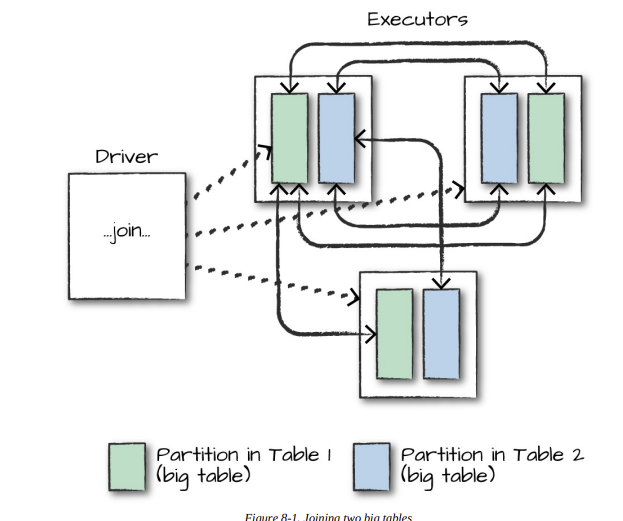
In a shuffle join, every node talks to every other node and they share data according to which
node has a certain key or set of keys (on which you are joining). These joins are expensive
because the network can become congested with traffic, especially if your data is not partitioned
well.

This join describes taking a big table of data and joining it to another big table of data. An
example of this might be a company that receives billions of messages every day from the
Internet of Things, and needs to identify the day-over-day changes that have occurred. The way
to do this is by joining on deviceId, messageType, and date in one column, and date - 1 day
in the other column.

In Figure 8-1, DataFrame 1 and DataFrame 2 are both large DataFrames. This means that all
worker nodes (and potentially every partition) will need to communicate with one another during
the entire join process (with no intelligent partitioning of data).

___Big table–to–small table___

When the table is small enough to fit into the memory of a single worker node, with some
breathing room of course, we can optimize our join. Although we can use a big table–to–big
table communication strategy, it can often be more efficient to use a broadcast join. What this
means is that we will replicate our small DataFrame onto every worker node in the cluster (be it
located on one machine or many). Now this sounds expensive. However, what this does is
prevent us from performing the all-to-all communication during the entire join process. Instead,
we perform it only once at the beginning and then let each individual worker node perform the
work without having to wait or communicate with any other worker node, as is depicted in
Figure 8-2.
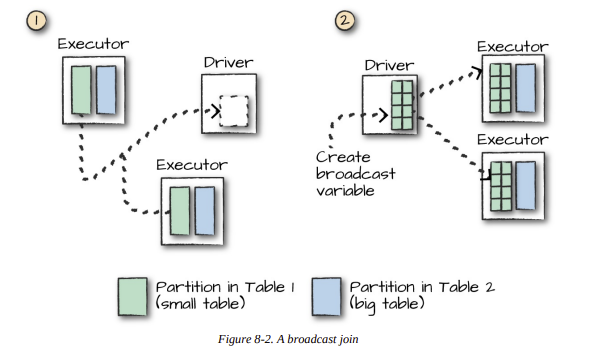
At the beginning of this join will be a large communication, just like in the previous type of join.
However, immediately after that first, there will be no further communication between nodes.
This means that joins will be performed on every single node individually, making CPU the
biggest bottleneck. For our current set of data, we can see that Spark has automatically set this up
as a broadcast join by looking at the explain plan:
~~~
val joinExpr = person.col("graduate_program") === graduateProgram.col("id")
person.join(graduateProgram, joinExpr).explain()
== Physical Plan ==
*BroadcastHashJoin [graduate_program#40], [id#5....
:- LocalTableScan [id#38, name#39, graduate_progr...
+- BroadcastExchange HashedRelationBroadcastMode(....
+- LocalTableScan [id#56, degree#57, departmen....
~~~
With the DataFrame API, we can also explicitly give the optimizer a hint that we would like to
use a broadcast join by using the correct function around the small DataFrame in question. In this
example, these result in the same plan we just saw; however, this is not always the case:
~~~
import org.apache.spark.sql.functions.broadcast
val joinExpr = person.col("graduate_program") === graduateProgram.col("id")
person.join(broadcast(graduateProgram), joinExpr).explain()
~~~
The SQL interface also includes the ability to provide hints to perform joins. These are not
enforced, however, so the optimizer might choose to ignore them. You can set one of these hints
by using a special comment syntax. MAPJOIN, BROADCAST, and BROADCASTJOIN all do the same
thing and are all supported:
~~~
-- in SQL
SELECT /*+ MAPJOIN(graduateProgram) */ * FROM person JOIN graduateProgram
ON person.graduate_program = graduateProgram.id
~~~
This doesn’t come for free either: if you try to broadcast something too large, you can crash your
driver node (because that collect is expensive). This is likely an area for optimization in the
future.

___Little table–to–little table___

When performing joins with small tables, it’s usually best to let Spark decide how to join them.
You can always force a broadcast join if you’re noticing strange behavior.

## Conclusion
In this chapter, we discussed joins, probably one of the most common use cases. One thing we
did not mention but is important to consider is if you partition your data correctly prior to a join,
you can end up with much more efficient execution because even if a shuffle is planned, if data
from two different DataFrames is already located on the same machine, Spark can avoid the
shuffle. Experiment with some of your data and try partitioning beforehand to see if you can
notice the increase in speed when performing those joins. In Chapter 9, we will discuss Spark’s
data source APIs. There are additional implications when you decide what order joins should
occur in. Because some joins act as filters, this can be a low-hanging improvement in your
workloads, as you are guaranteed to reduce data exchanged over the network.

The next chapter will depart from user manipulation, as we’ve seen in the last several chapters,
and touch on reading and writing data using the Structured APIs.